In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
#import tqdm
from src import models, utils#, parametrizations,tasks,running#,tasks
import os 

%load_ext autoreload
%autoreload 2

plt.rcParams.update({
    'font.size': 25,  # Update global font size
    'axes.titlesize': 20,  # Update axes title font size
    'axes.labelsize': 10,  # Update axes label font size
    'xtick.labelsize': 20,  # Update xtick label font size
    'ytick.labelsize': 20,  # Update ytick label font size
})
plt.style.use("seaborn-poster")

/tmp/ipykernel_2726270/2815468151.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-poster")


In [2]:

def generate_sine_waves(n, T, frequency=1, time_step=0.01):
    t = np.arange(0, T, time_step)
    matrix = np.zeros((n, len(t)))

    for i in range(n):
        amplitude = np.random.uniform(0.5, 1.0)
        phase = np.random.uniform(0, 2 * np.pi)
        matrix[i, :] = amplitude * np.sin(2 * np.pi * frequency * t + phase)

    return t, matrix

  


def plot_simulation_results(t, sine_waves, state):
    n = sine_waves.shape[0]
    
    plt.figure(figsize=(10, 5))
    for i in range(n):
        plt.plot(t, sine_waves[i, :], label=f'Input sine wave {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Sine waves input')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    for i in range(n):
        plt.plot(t, state[i, :], label=f'State {i+1}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('System state')
    plt.legend()
    plt.show()



In [3]:
def generate_random_hierarchcal_adjacency(p, s):
    # p number of nodes
    # s sparsity

    A = np.random.choice([0,1],p = [s, 1-s],size = (p,p))
    return np.tril(A) - np.diag(np.diag(A))

In [27]:
class GW_Net:
    def __init__(self, hidden_size = 32, p = 5, g = 1.5, s_max = 1, arch = 'all'):
        self.hidden_size = hidden_size
        self.p = p
        self.g = g 
        self.s_max = s_max
        self.arch = arch
        self.build_GW_Net()
        
        
    def build_GW_Net(self):
        # hidden_size = number of units per subnetwork
        # p = number of subnetworks
        # g = initial recurrent magnitude for h2h matrices
        # s_max = largest singular value of h2h matrices

        ns = [self.hidden_size for _ in range(self.p)]

        if self.arch == 'GW':
            A_tril = torch.zeros((len(ns), len(ns)))
            A_tril[-1, :] = 1
            B_mask = utils.create_mask_given_A(A_tril, ns)
            B = B_mask.detach().cpu().numpy()
            B = (B + B.T)
            B[B == 2] = 0
            
            
        if self.arch == 'hier':
            A_tril = generate_random_hierarchcal_adjacency(self.p, 0)
            B_mask = utils.create_mask_given_A(A_tril, ns)
            B = B_mask.detach().cpu().numpy()
           
        if self.arch == 'all':
            A_tril = np.ones((self.p,self.p)) - np.eye(self.p)
            B_mask = utils.create_mask_given_A(A_tril, ns)
            B = B_mask.detach().cpu().numpy()
            B = (B + B.T)

        if self.arch == 'random':
            A_tril = np.random.choice([0,1],p = [0.2, 0.8],size = (self.p,self.p)) - np.eye(self.p)
            B_mask = utils.create_mask_given_A(A_tril, ns,use_upper = True)
            B = B_mask.detach().cpu().numpy()



        # adaptable weights
        A = np.eye(int(self.hidden_size*self.p))#np.random.normal(0,1/np.sqrt(hidden_size),(sum(ns),sum(ns)))
        A = A*B

        # intra-areal weights, singular values less than or equal to unity
        blocks = utils.create_mask_given_A(np.eye(len(ns)), ns)
        blocks = blocks.detach().cpu().numpy()
        W = np.random.normal(0,self.g/np.sqrt(self.hidden_size),(sum(ns),sum(ns)))
        W *= blocks

        # sparsify h2h weights
        random_W_mask = np.random.choice([0,1],p = [0.5,0.5],size = (sum(ns),sum(ns)))
        W *= random_W_mask

        D = np.eye(sum(ns))#np.random.normal(0,1,sum(ns),sum(ns))

        # project h2h to unit norm
        u,s,vt = np.linalg.svd(W)
        s = np.minimum(self.s_max,s)
        W = u @ np.diag(s) @ vt

        self.W, self.F, self.A, self.B, self.D = W, F, A, B, D

    def forward(self, x, u):
        # Define the forward computation here
        
        return -x + self.W @ np.tanh(x) + self.A @ np.maximum(0,self.D @ x)  + u

    def __call__(self, x, u):
        return self.forward(x, u)



In [28]:
def run_gp_adaptation(net = None, hidden_size = 32, p = 5, dt = 0.005, T = 150, trials = 1 , eta = 1, gain = 1, sigma = 5, lam = 1):

    n = int(net.hidden_size*net.p)
    ts = np.arange(0, T, dt)


    es = np.zeros((trials,len(ts)))

    for trial in range(trials):

        net.A = np.eye(n)*net.B

        x = 0*np.random.normal(0, 1/np.sqrt(n), n)

        #_, sine_waves = generate_sine_waves(n, T, time_step= dt, frequency = 2)
        u = utils.generate_GP(T = T,time_step = 0.1,n = n,sigma = sigma)
        u = utils.upscale_timeseries(u.T, len(ts))
        u = u.T
        
        #_, sine_waves_desired = generate_sine_waves(n, T, time_step = dt, frequency = 1)
        xs_d = utils.generate_GP(T = T,time_step = 0.1,n = n,sigma = sigma)
        xs_d = utils.upscale_timeseries(xs_d.T, len(ts))
        xs_d = xs_d.T

        
        states = []

        for k, _ in enumerate(ts):
            
            states.append(x)

            e = x - xs_d[:,k]
            es[trial,k] = (1/np.sqrt(n))*np.linalg.norm(e)            

            net.A = net.A + dt*(-lam*net.A -eta*np.outer(e,np.maximum(0,net.D@x))*net.B)
            f = net(x, u[:,k] - gain*e)            

            x = x +  dt*f

        states = np.stack(states)
        
    
    return es, states, xs_d, u,ts
    

Memory Guided Adaptive Control Experiments

In [96]:
gain = 0
sigma = 2
nu = 0.1

trials = 20

GW_RNN_Stable = GW_Net(g = 1.5, s_max = 1.0, hidden_size = 16, p = 10, arch = 'GW')

es_mems = []

for trial in range(trials):    

    es,states,states_desired,u,ts = run_gp_adaptation(net = GW_RNN_Stable, T = 300, dt = 0.1, eta = 1, gain = gain, lam = 0.1, sigma = sigma, trials = 1)
    es_mems.append(np.mean(es))

    GW_RNN_Stable.D += nu*GW_RNN_Stable.A
    





In [4]:

num_gain = 10
num_g = 10
gain_range = np.linspace(0,1,num_gain)
g_range = np.linspace(0.5,3,num_g)

es_all = np.zeros((num_g,num_gain))

#trials = 20
'''
for i,g in enumerate(g_range):
    GW_RNN_Stable = GW_Net(g = g, s_max = g, hidden_size = 32, p = 10, arch = 'random')
    for j,gain in enumerate(gain_range):        
        es,states,states_desired,u,ts = run_gp_adaptation(net = GW_RNN_Stable, T = 300, dt = 0.05, eta = 0.1, gain = gain, lam = 0.0, sigma = 2, trials = 1)
        es_all[i,j] = np.mean(es)

'''

"\nfor i,g in enumerate(g_range):\n    GW_RNN_Stable = GW_Net(g = g, s_max = g, hidden_size = 32, p = 10, arch = 'random')\n    for j,gain in enumerate(gain_range):        \n        es,states,states_desired,u,ts = run_gp_adaptation(net = GW_RNN_Stable, T = 300, dt = 0.05, eta = 0.1, gain = gain, lam = 0.0, sigma = 2, trials = 1)\n        es_all[i,j] = np.mean(es)\n\n"

In [ ]:
#np.save('/home/leo/rnns-of-rnns/data/es_gain_vs_stability.npy',es_all)

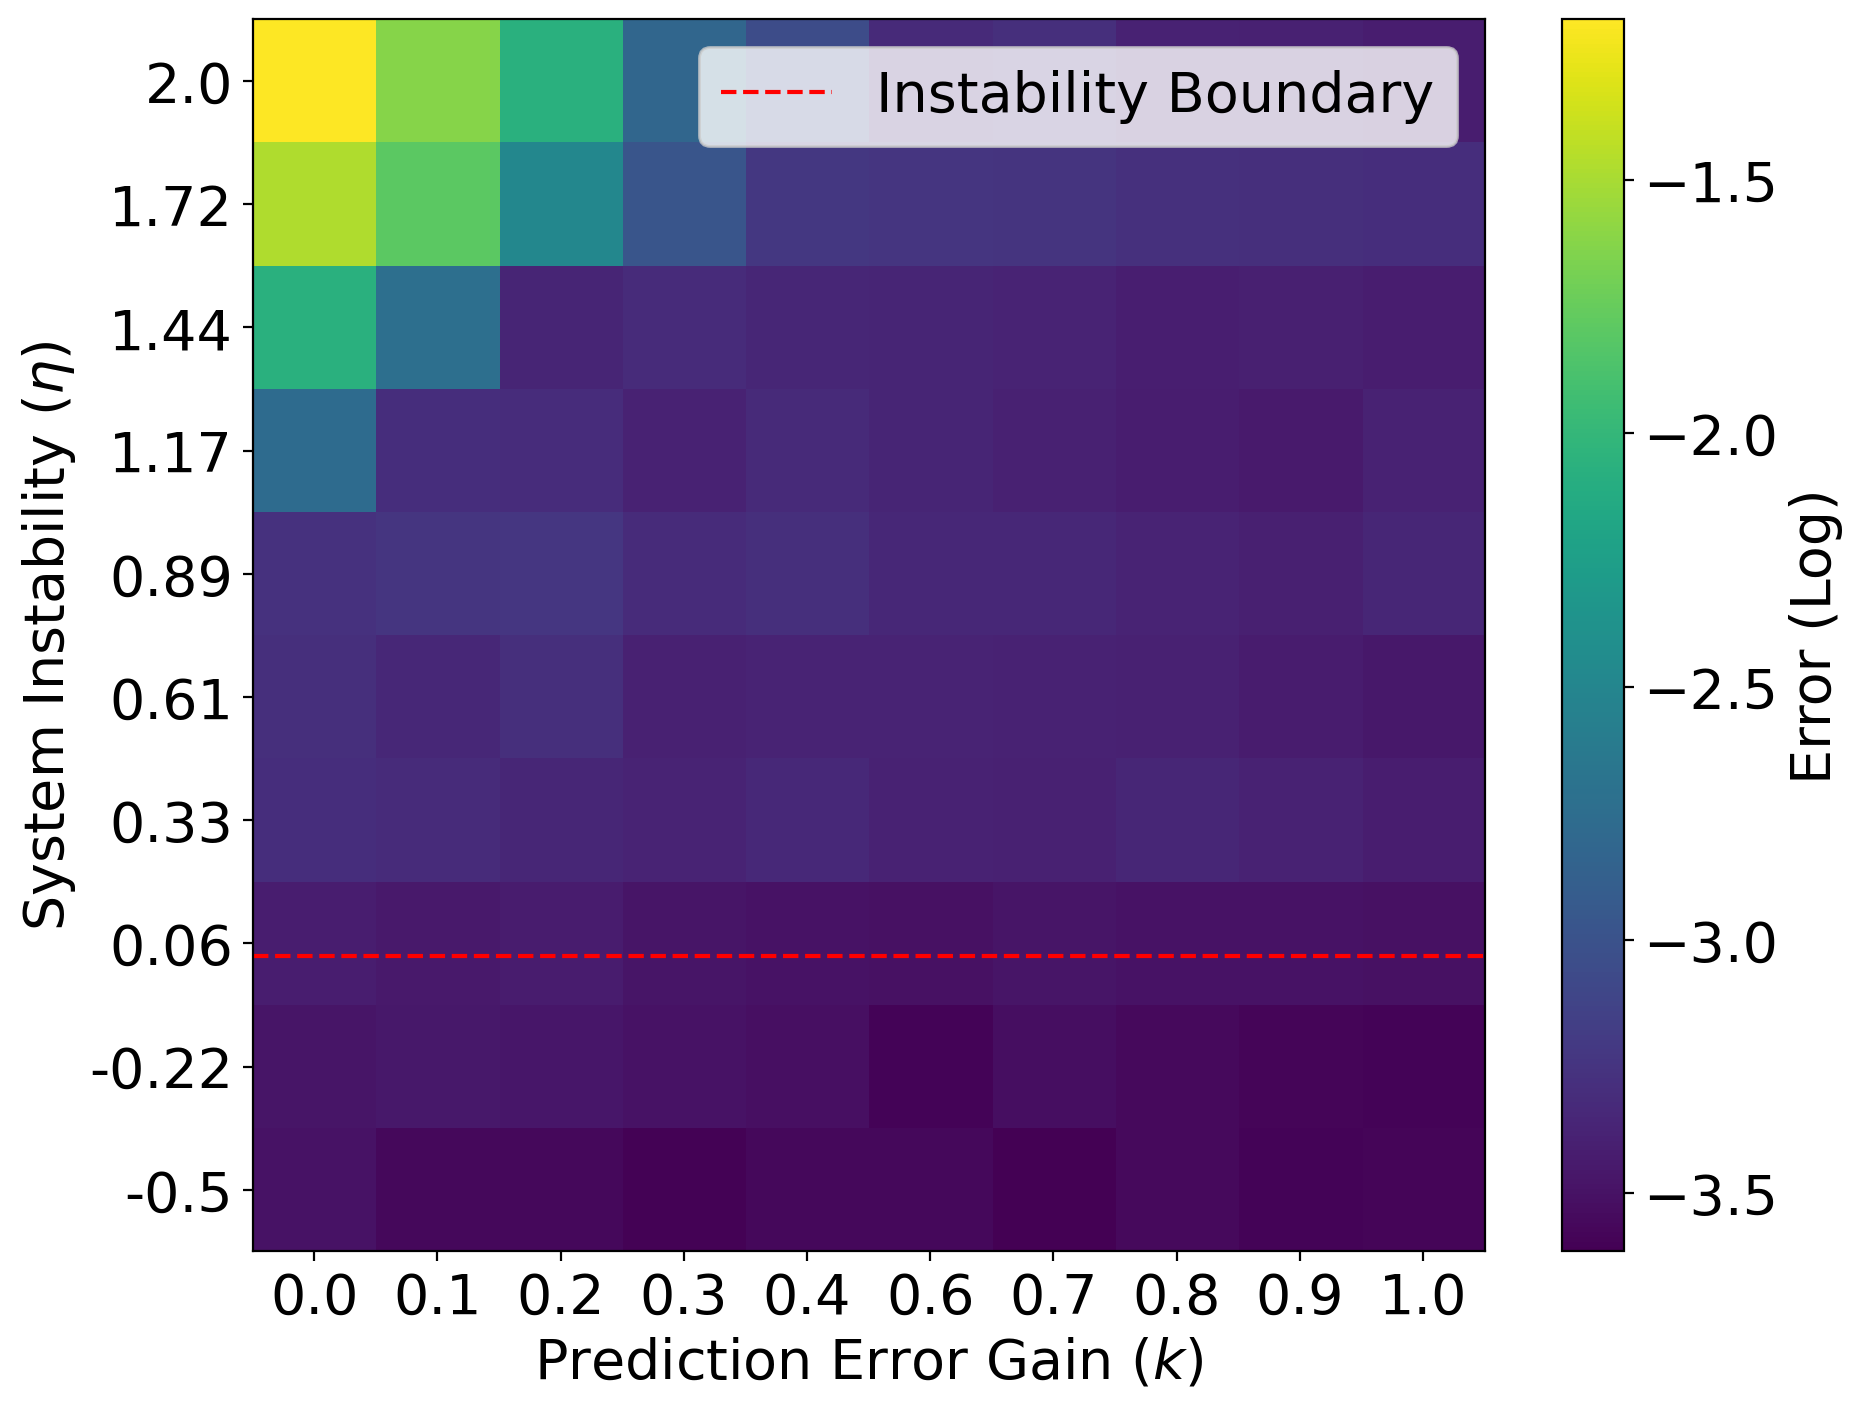

In [50]:
#plt.style.use("default")

es_all = np.load('/home/leo/rnns-of-rnns/data/es_gain_vs_stability.npy')

fig = plt.figure(dpi = 200,figsize = (10,8))
plt.rcParams.update({
    'font.size': 20,  # Update global font size
    'axes.titlesize': 20,  # Update axes title font size
    'axes.labelsize': 20,  # Update axes label font size
    'xtick.labelsize': 20,  # Update xtick label font size
    'ytick.labelsize': 20,  # Update ytick label font size
})

plt.imshow(np.log(es_all),origin='lower',aspect='equal')
plt.colorbar(label = 'Error (Log)')
plt.xlabel(r'Prediction Error Gain ($k$)')
plt.ylabel(r'System Instability ($\eta$)')


# Label the axes
x_positions = np.linspace(0, len(gain_range)-1, len(gain_range))  # 5 ticks
x_labels = np.around(gain_range,1) # labels corresponding to the ticks
#plt.xticks(x_positions, x_labels);

y_positions = np.linspace(0, len(g_range)-1, len(g_range))  # 5 ticks
y_labels = np.around(g_range-1,2)  # labels corresponding to the ticks
#plt.yticks(y_positions, y_labels);

plt.xticks(x_positions, x_labels);
plt.yticks(y_positions, y_labels);

plt.hlines(1.9,-0.5,9.5,'r',linestyle = '--',label = 'Instability Boundary')

plt.legend()

plt.savefig('/home/leo/rnns-of-rnns/results/plots/error_vs_fb_gain_stability.png',dpi = 300)

In [34]:
y_positions

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [26]:
GW_RNN_Stable.F

<module 'torch.nn.functional' from '/home/leo/anaconda3/envs/rnns-of-rnns-env/lib/python3.8/site-packages/torch/nn/functional.py'>

In [9]:
GW_RNN_Stable = GW_Net(g = 1.5, s_max = 1.0, hidden_size = 16, p = 10, arch = 'random')
es,states,states_desired,u,ts = run_gp_adaptation(net = GW_RNN_Stable, T = 300, dt = 0.1, eta = 1, gain = gain, lam = 0, sigma = sigma, trials = 1)

gain_range = np.linspace(0,3,10)
sigma_range = np.linspace(1,10,10)


'''
e_sweep = np.zeros((len(gain_range),len(sigma_range)))

for i,gain in enumerate(gain_range):
    for j,sigma in enumerate(sigma_range):
        es,states,states_desired,u,ts = run_gp_adaptation(net = GW_RNN_Stable, T = 300, dt = 0.1, eta = 1, gain = gain, lam = 0, sigma = sigma, trials = 1)
        e_sweep[i,j] = np.mean(es)

''';
        

'\ne_sweep = np.zeros((len(gain_range),len(sigma_range)))\n\nfor i,gain in enumerate(gain_range):\n    for j,sigma in enumerate(sigma_range):\n        es,states,states_desired,u,ts = run_gp_adaptation(net = GW_RNN_Stable, T = 300, dt = 0.1, eta = 1, gain = gain, lam = 0, sigma = sigma, trials = 1)\n        e_sweep[i,j] = np.mean(es)\n\n'

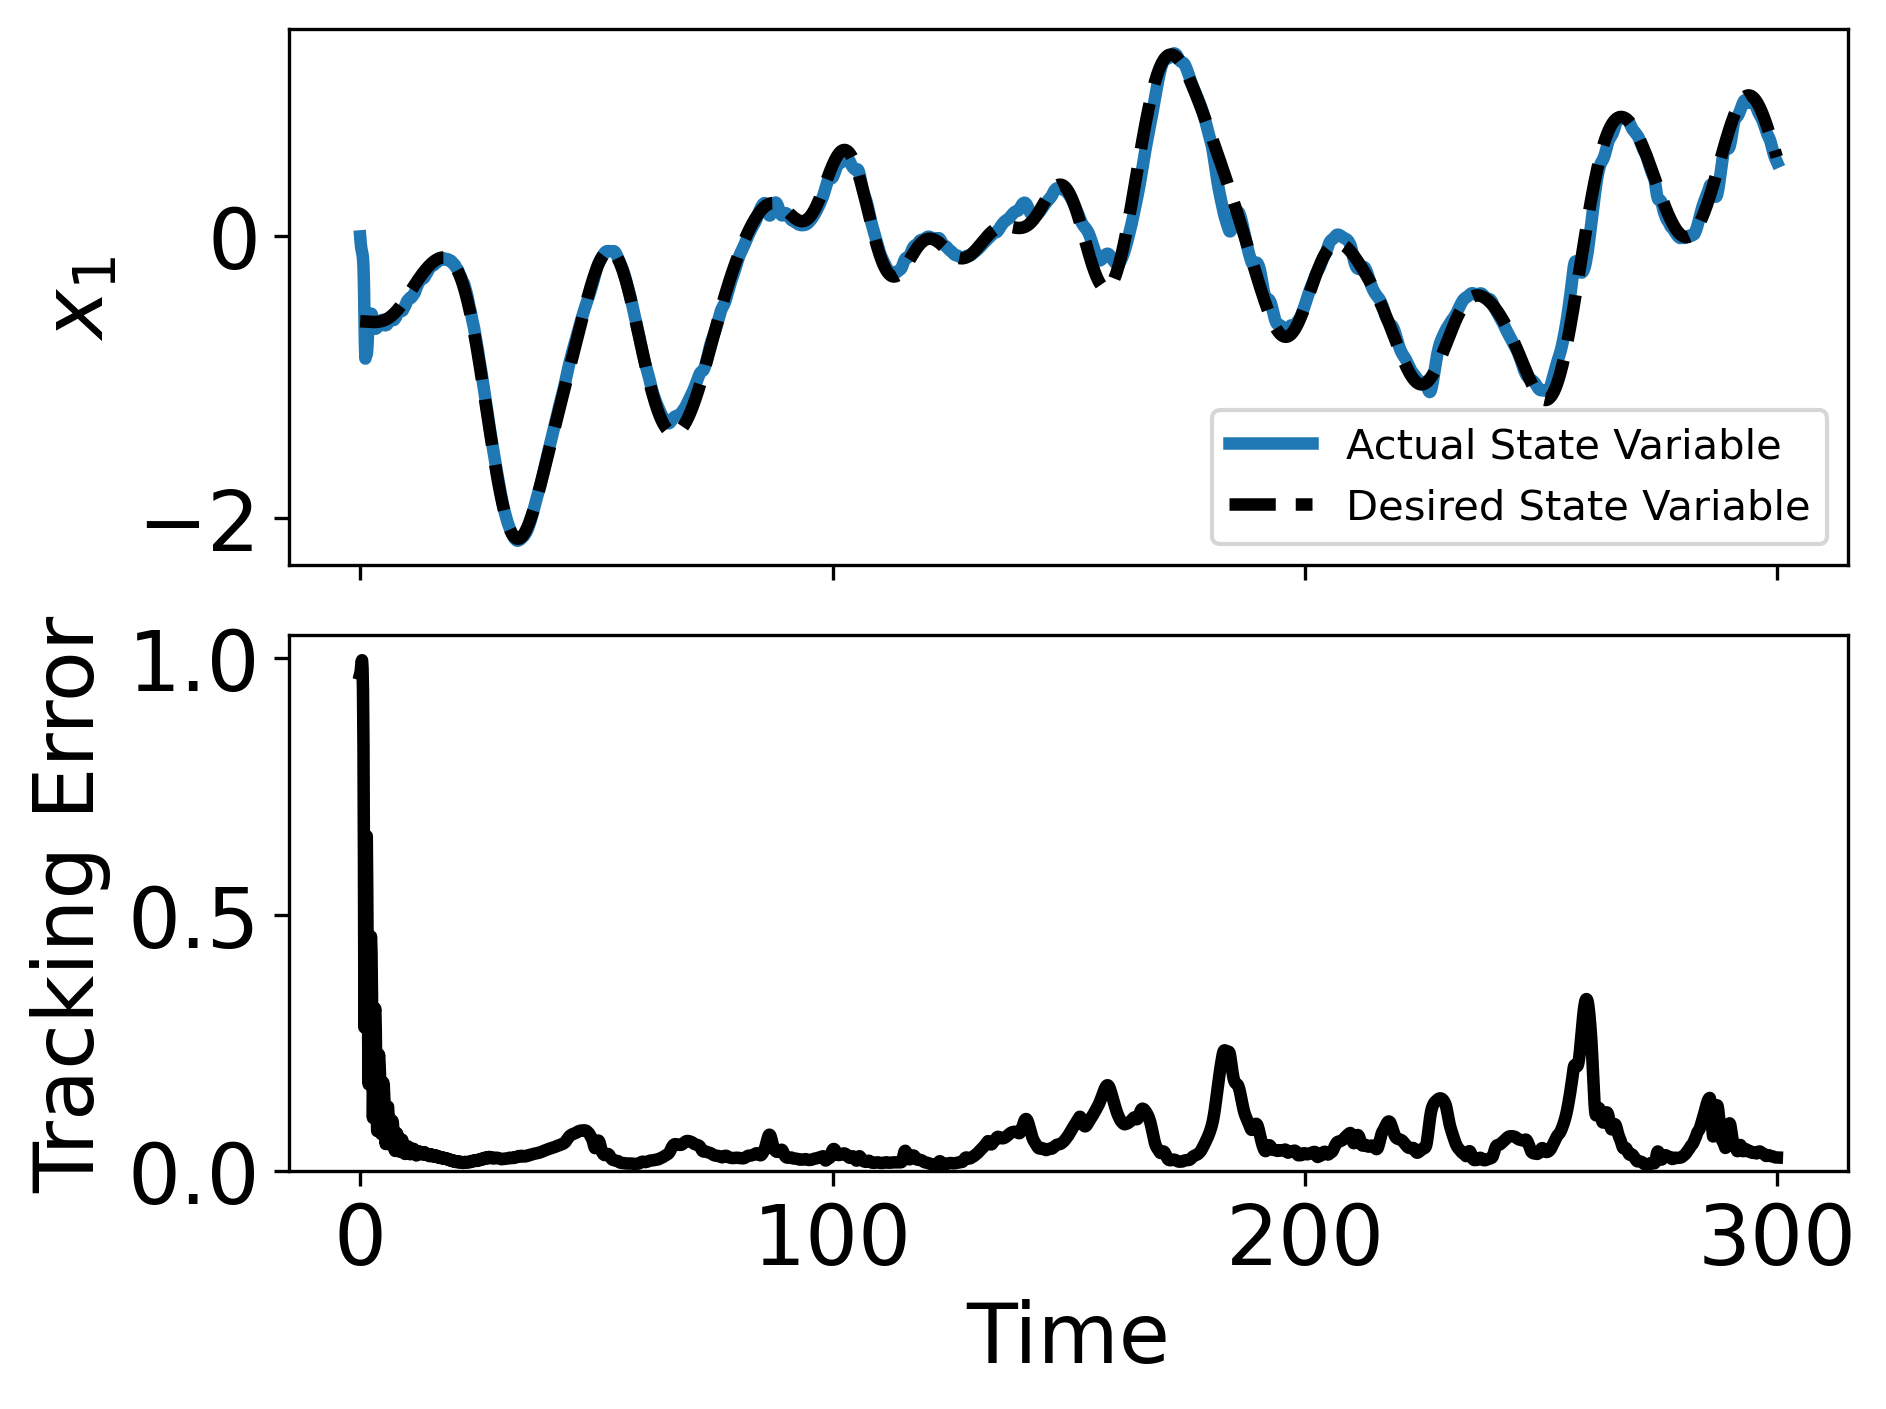

In [59]:
plt.style.use("default")
plt.rcParams.update({
    'font.size': 10,  # Update global font size
    'axes.titlesize': 20,  # Update axes title font size
    'axes.labelsize': 20,  # Update axes label font size
    'xtick.labelsize': 20,  # Update xtick label font size
    'ytick.labelsize': 20,  # Update ytick label font size
})

fig,axs = plt.subplots(2,1,dpi = 300,sharex = True)

GW_RNN_Stable = GW_Net(g = 1.5, s_max = 1.0, hidden_size = 16, p = 10, arch = 'GW')
es,states,states_desired,u,ts = run_gp_adaptation(net = GW_RNN_Stable, T = 300, dt = 0.1, eta = 1, gain = 0, lam = 0, sigma = 3, trials = 1)
mean_e = np.mean(es, axis = 0)

axs[0].plot(ts,states[:,1],label = r'Actual State Variable',linewidth = 3)
axs[0].plot(ts,states_desired[1,:],label = r'Desired State Variable',color = 'k',linestyle = '--',linewidth = 3)
axs[0].legend()
axs[0].set_ylabel(r'$x_1$')

axs[1].plot(ts,mean_e,linewidth = 3,color = 'k')
axs[1].set_ylim(0)
axs[1].set_xlabel('Time')
axs[1].set_ylabel(r'Tracking Error')

plt.tight_layout()


#plt.savefig('/home/leo/rnns-of-rnns/results/plots/tracking_error_gw.png',dpi = 300)

(0.0, 1.0989569408314295)

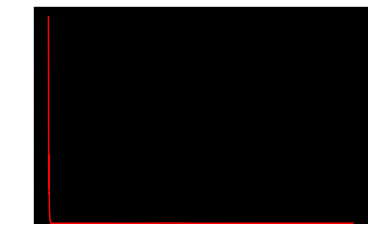

In [469]:
#mean_stable = np.mean(es, axis = 0)
#plt.plot(mean_stable);

mean_e = np.mean(es, axis = 0)
std_e = np.std(es, axis = 0)
standard_error = std_e/np.sqrt(len(es))






plt.plot(ts, mean_e,color = 'r')
plt.fill_between(ts,mean_e - standard_error, mean_e + standard_error, alpha=0.8, label='Standard Deviation')
plt.ylim(0)

In [10]:
e_sweep_gw = np.load('/home/leo/rnns-of-rnns/data/e_sweep_gw.npy')
e_sweep_hier = np.load('/home/leo/rnns-of-rnns/data/e_sweep_hier.npy')
e_sweep_random = np.load('/home/leo/rnns-of-rnns/data/e_sweep_random.npy')

GW_RNN_Stable = GW_Net(g = 1.5, s_max = 1.0, hidden_size = 16, p = 10, arch = 'GW')
es,states,states_desired,u,ts = run_gp_adaptation(net = GW_RNN_Stable, T = 300, dt = 0.1, eta = 1, gain = 0, lam = 0, sigma = 1, trials = 1)
Hier_RNN_Stable = GW_Net(g = 1.5, s_max = 1.0, hidden_size = 16, p = 10, arch = 'hier')
es,states,states_desired,u,ts = run_gp_adaptation(net = Hier_RNN_Stable, T = 300, dt = 0.1, eta = 1, gain = 0, lam = 0, sigma = 1, trials = 1)
random_RNN_Stable = GW_Net(g = 1.5, s_max = 1.0, hidden_size = 16, p = 10, arch = 'random')
es,states,states_desired,u,ts = run_gp_adaptation(net = random_RNN_Stable, T = 300, dt = 0.1, eta = 1, gain = 0, lam = 0, sigma = 1, trials = 1)

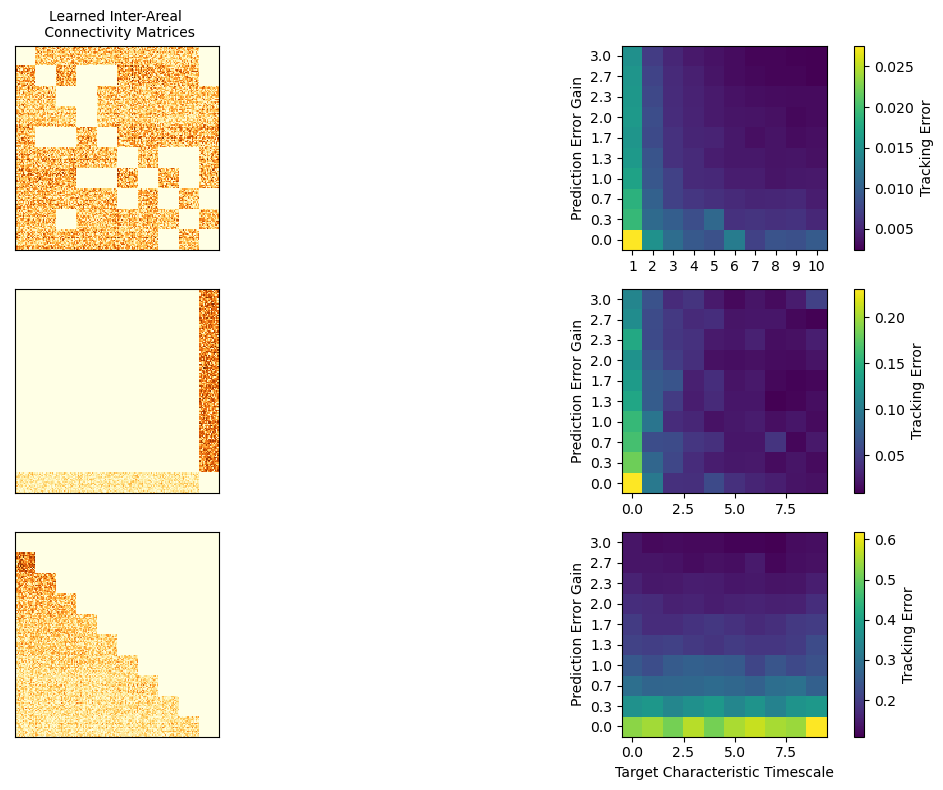

In [18]:
plt.style.use("default")

# Label the axes
x_positions = np.linspace(0, e_sweep_gw.shape[1]-1, len(sigma_range))  # 5 ticks
x_labels = sigma_range.astype(int)  # labels corresponding to the ticks
#plt.xticks(x_positions, x_labels);

y_positions = np.linspace(0, e_sweep_gw.shape[0]-1, len(gain_range))  # 5 ticks
y_labels = np.around(gain_range,1)  # labels corresponding to the ticks
#plt.yticks(y_positions, y_labels);






fig,axs = plt.subplots(3,2,dpi = 100,figsize = (12,8))


axs[0,0].matshow(np.log(np.abs(random_RNN_Stable.A) + 0.1),cmap = 'YlOrBr')
axs[1,0].matshow(np.log(np.abs(GW_RNN_Stable.A) + 0.1),cmap = 'YlOrBr')
axs[2,0].matshow(np.log(np.abs(Hier_RNN_Stable.A) + 0.1),cmap = 'YlOrBr')


axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].set_title('Learned Inter-Areal \n Connectivity Matrices',fontsize = 10)

axs[1,0].set_xticks([])
axs[1,0].set_yticks([])

axs[2,0].set_xticks([])
axs[2,0].set_yticks([])

ms = axs[0,1].imshow(e_sweep_random,origin='lower',aspect='equal')
fig.colorbar(ms, ax=axs[0,1], fraction=0.046, pad=0.04,label = 'Tracking Error')
axs[0,1].set_xticks(x_positions, x_labels)
axs[0,1].set_yticks(y_positions, y_labels)
axs[0,1].set_ylabel('Prediction Error Gain')


ms = axs[1,1].imshow(e_sweep_gw,origin='lower',aspect='equal')
fig.colorbar(ms, ax=axs[1,1], fraction=0.046, pad=0.04,label = 'Tracking Error')
axs[1,1].set_yticks(y_positions, y_labels)
axs[1,1].set_yticks(y_positions, y_labels)
axs[1,1].set_ylabel('Prediction Error Gain')

ms = axs[2,1].imshow(e_sweep_hier,origin='lower',aspect='equal')
fig.colorbar(ms, ax=axs[2,1], fraction=0.046, pad=0.04,label = 'Tracking Error')
axs[2,1].set_yticks(y_positions, y_labels)
axs[2,1].set_xlabel('Target Characteristic Timescale')
axs[2,1].set_ylabel('Prediction Error Gain')

plt.tight_layout()

plt.savefig('/home/leo/rnns-of-rnns/results/plots/interareal_matrices.png',dpi = 300)

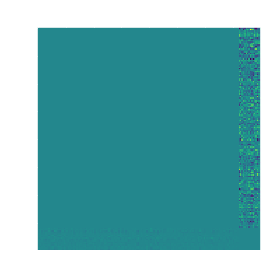

In [551]:
plt.matshow(GW_RNN_Stable.A)